In [1]:
import polars as pl
pl.Config.set_fmt_str_lengths(50)


polars.config.Config

In [2]:
train = pl.read_csv("m5-forecasting-accuracy\sales_train_validation.csv")
calendar = pl.read_csv("m5-forecasting-accuracy\calendar.csv")
sell_prices = pl.read_csv("m5-forecasting-accuracy\sell_prices.csv")

In [3]:
calendar

date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
str,i64,str,i64,i64,i64,str,str,str,str,str,i64,i64,i64
"""2011-01-29""",11101,"""Saturday""",1,1,2011,"""d_1""",null,null,null,null,0,0,0
"""2011-01-30""",11101,"""Sunday""",2,1,2011,"""d_2""",null,null,null,null,0,0,0
"""2011-01-31""",11101,"""Monday""",3,1,2011,"""d_3""",null,null,null,null,0,0,0
"""2011-02-01""",11101,"""Tuesday""",4,2,2011,"""d_4""",null,null,null,null,1,1,0
"""2011-02-02""",11101,"""Wednesday""",5,2,2011,"""d_5""",null,null,null,null,1,0,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2016-06-15""",11620,"""Wednesday""",5,6,2016,"""d_1965""",null,null,null,null,0,1,1
"""2016-06-16""",11620,"""Thursday""",6,6,2016,"""d_1966""",null,null,null,null,0,0,0
"""2016-06-17""",11620,"""Friday""",7,6,2016,"""d_1967""",null,null,null,null,0,0,0


In [4]:
# Step 1: Melt sales data
train = (
    train
    .melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"])
    .join(
        calendar.select(
            pl.col("d"),
            pl.col("date"),
            pl.col("wm_yr_wk")  # include weekly mapping
        ),
        left_on="variable",
        right_on="d",
    )
    .with_columns(
        pl.col("date").str.strptime(pl.Date)
    )
    .with_columns(
        # weekday: Mon=0, …, Sat=5, Sun=6
        # days_to_sat = (5 - weekday) % 7
        (pl.col("date") 
           + pl.duration(days=(5 - pl.col("date").dt.weekday()) % 7)
        ).alias("week_end")
    )
)

# Step 2: Create unique_id
train = train.with_columns(
    (
        pl.col("dept_id") + "_" + 
        pl.col("store_id") + "_" + 
        pl.col("cat_id") + "_" + 
        pl.col("item_id") + "_" + 
        pl.col("state_id")
    ).alias("unique_id")
)


C:\Users\janli\AppData\Local\Temp\ipykernel_23144\1737731747.py:4: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  .melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"])


In [5]:

# Step 3: Aggregate weekly sales
weekly_train = (
    train
    .group_by(["unique_id", "item_id", "store_id", "week_end", "wm_yr_wk", "state_id"])
    .agg(
        pl.col("value").sum().alias("y")
    )
    .sort(["unique_id", "week_end"])
    .rename({"week_end": "ds"})
)



In [6]:
weekly_train

unique_id,item_id,store_id,ds,wm_yr_wk,state_id,y
str,str,str,date,i64,str,i64
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""","""FOODS_1_001""","""CA_1""",2011-02-04,11101,"""CA""",10
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""","""FOODS_1_001""","""CA_1""",2011-02-11,11102,"""CA""",6
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""","""FOODS_1_001""","""CA_1""",2011-02-18,11103,"""CA""",10
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""","""FOODS_1_001""","""CA_1""",2011-02-25,11104,"""CA""",13
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""","""FOODS_1_001""","""CA_1""",2011-03-04,11105,"""CA""",15
…,…,…,…,…,…,…
"""HOUSEHOLD_2_WI_3_HOUSEHOLD_HOUSEHOLD_2_516_WI""","""HOUSEHOLD_2_516""","""WI_3""",2016-04-01,11609,"""WI""",0
"""HOUSEHOLD_2_WI_3_HOUSEHOLD_HOUSEHOLD_2_516_WI""","""HOUSEHOLD_2_516""","""WI_3""",2016-04-08,11610,"""WI""",0
"""HOUSEHOLD_2_WI_3_HOUSEHOLD_HOUSEHOLD_2_516_WI""","""HOUSEHOLD_2_516""","""WI_3""",2016-04-15,11611,"""WI""",0


In [7]:
import polars as pl

# assume df has columns: unique_id, item_id, store_id, ds, wm_yr_wk, state_id, y
df = weekly_train

df = (
    df
    # 1) log-transform y
    .with_columns(
        pl.col("y").log().alias("log_y")
    )
    # 2) diff the log, partitioned by unique_id
    .with_columns(
        pl.col("log_y")
          .diff()                       # first difference
          .over("unique_id")            # per group
          .alias("diff_log_y")
    )
    # 3) undo the diff: cumulative sum of the diffs + the very first log value per group
    .with_columns(
        (
            pl.col("diff_log_y")
              .cum_sum()                  # running total of diffs
              .over("unique_id")
            + pl.col("log_y")
              .first().over("unique_id") # group’s initial log_y
        ).alias("undiff_log_y")
    )
    # 4) undo the log: exponentiate the “undiff_log_y”
    .with_columns(
        pl.col("undiff_log_y")
          .exp()
          .alias("reconstructed_y")
    )
)

df

unique_id,item_id,store_id,ds,wm_yr_wk,state_id,y,log_y,diff_log_y,undiff_log_y,reconstructed_y
str,str,str,date,i64,str,i64,f64,f64,f64,f64
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""","""FOODS_1_001""","""CA_1""",2011-02-04,11101,"""CA""",10,2.302585,null,null,null
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""","""FOODS_1_001""","""CA_1""",2011-02-11,11102,"""CA""",6,1.791759,-0.510826,1.791759,6.0
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""","""FOODS_1_001""","""CA_1""",2011-02-18,11103,"""CA""",10,2.302585,0.510826,2.302585,10.0
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""","""FOODS_1_001""","""CA_1""",2011-02-25,11104,"""CA""",13,2.564949,0.262364,2.564949,13.0
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""","""FOODS_1_001""","""CA_1""",2011-03-04,11105,"""CA""",15,2.70805,0.143101,2.70805,15.0
…,…,…,…,…,…,…,…,…,…,…
"""HOUSEHOLD_2_WI_3_HOUSEHOLD_HOUSEHOLD_2_516_WI""","""HOUSEHOLD_2_516""","""WI_3""",2016-04-01,11609,"""WI""",0,-inf,NaN,NaN,NaN
"""HOUSEHOLD_2_WI_3_HOUSEHOLD_HOUSEHOLD_2_516_WI""","""HOUSEHOLD_2_516""","""WI_3""",2016-04-08,11610,"""WI""",0,-inf,NaN,NaN,NaN
"""HOUSEHOLD_2_WI_3_HOUSEHOLD_HOUSEHOLD_2_516_WI""","""HOUSEHOLD_2_516""","""WI_3""",2016-04-15,11611,"""WI""",0,-inf,NaN,NaN,NaN


In [8]:

# Step 4: Join sell_price to weekly data
weekly_train = (
    weekly_train
    .join(
        sell_prices,
        left_on=["store_id", "item_id", "wm_yr_wk"],
        right_on=["store_id", "item_id", "wm_yr_wk"],
        how="left"
    )
)

In [9]:
from mlforecast import MLForecast
from lightgbm import LGBMRegressor
from mlforecast.lag_transforms import RollingMean, ExpandingStd


mlf = MLForecast(
    models=[],
    freq='1w',  # Weekly frequency
    lags=[1, 2, 3, 4, 8],  # Custom lag features
    lag_transforms={
        1: [ExpandingStd()],
        7: [RollingMean(window_size=7, min_samples=1), RollingMean(window_size=14)]
    },
    date_features=['month', 'week'],  # Calendar features
    num_threads=4
)


In [10]:
weekly_train

unique_id,item_id,store_id,ds,wm_yr_wk,state_id,y,sell_price
str,str,str,date,i64,str,i64,f64
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""","""FOODS_1_001""","""CA_1""",2011-02-04,11101,"""CA""",10,2.0
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""","""FOODS_1_001""","""CA_1""",2011-02-11,11102,"""CA""",6,2.0
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""","""FOODS_1_001""","""CA_1""",2011-02-18,11103,"""CA""",10,2.0
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""","""FOODS_1_001""","""CA_1""",2011-02-25,11104,"""CA""",13,2.0
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""","""FOODS_1_001""","""CA_1""",2011-03-04,11105,"""CA""",15,2.0
…,…,…,…,…,…,…,…
"""HOUSEHOLD_2_WI_3_HOUSEHOLD_HOUSEHOLD_2_516_WI""","""HOUSEHOLD_2_516""","""WI_3""",2016-04-01,11609,"""WI""",0,5.94
"""HOUSEHOLD_2_WI_3_HOUSEHOLD_HOUSEHOLD_2_516_WI""","""HOUSEHOLD_2_516""","""WI_3""",2016-04-08,11610,"""WI""",0,5.94
"""HOUSEHOLD_2_WI_3_HOUSEHOLD_HOUSEHOLD_2_516_WI""","""HOUSEHOLD_2_516""","""WI_3""",2016-04-15,11611,"""WI""",0,5.94


In [11]:
import polars as pl
from typing import List

def add_weekly_window_sums(
    df: pl.DataFrame,
    value_cols: List[str],
    id_col: str = "unique_id",
    date_col: str = "ds"
) -> pl.DataFrame:
    """
    For weekly data, compute forward‐looking weekly sums (future only):
      - {col}_sum_1_2 : y(t+1) + y(t+2)
      - {col}_sum_3_4 : y(t+3) + y(t+4)
      - {col}_sum_5_8 : y(t+5) + … + y(t+8)
    """
    df_sorted = df.sort([id_col, date_col])

    exprs: List[pl.Expr] = []
    for col in value_cols:
        exprs += [
            # weeks 1–2 ahead
            (
                pl.col(col).shift(-1).over(id_col)
                + pl.col(col).shift(-2).over(id_col)
            ).alias(f"{col}_sum_1_2"),

            # weeks 3–4 ahead
            (
                pl.col(col).shift(-3).over(id_col)
                + pl.col(col).shift(-4).over(id_col)
            ).alias(f"{col}_sum_3_4"),

            # weeks 5–8 ahead
            sum(
                (pl.col(col).shift(-i).over(id_col) for i in range(5, 9)),
                pl.lit(0)
            ).alias(f"{col}_sum_5_8"),
        ]

    target_cols = [
        f"{col}_sum_{w1}_{w2}"
        for col in value_cols
        for (w1, w2) in [(1,2), (3,4), (5,8)]
    ]

    return (
        df_sorted
          .with_columns(exprs)
          .select([id_col, date_col, *target_cols])
          .drop_nulls(subset=target_cols)
    )


In [12]:
weekly_train

unique_id,item_id,store_id,ds,wm_yr_wk,state_id,y,sell_price
str,str,str,date,i64,str,i64,f64
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""","""FOODS_1_001""","""CA_1""",2011-02-04,11101,"""CA""",10,2.0
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""","""FOODS_1_001""","""CA_1""",2011-02-11,11102,"""CA""",6,2.0
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""","""FOODS_1_001""","""CA_1""",2011-02-18,11103,"""CA""",10,2.0
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""","""FOODS_1_001""","""CA_1""",2011-02-25,11104,"""CA""",13,2.0
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""","""FOODS_1_001""","""CA_1""",2011-03-04,11105,"""CA""",15,2.0
…,…,…,…,…,…,…,…
"""HOUSEHOLD_2_WI_3_HOUSEHOLD_HOUSEHOLD_2_516_WI""","""HOUSEHOLD_2_516""","""WI_3""",2016-04-01,11609,"""WI""",0,5.94
"""HOUSEHOLD_2_WI_3_HOUSEHOLD_HOUSEHOLD_2_516_WI""","""HOUSEHOLD_2_516""","""WI_3""",2016-04-08,11610,"""WI""",0,5.94
"""HOUSEHOLD_2_WI_3_HOUSEHOLD_HOUSEHOLD_2_516_WI""","""HOUSEHOLD_2_516""","""WI_3""",2016-04-15,11611,"""WI""",0,5.94


In [13]:
weekly_sums = add_weekly_window_sums(weekly_train, ["y"])


In [14]:
weekly_train = weekly_train.join(weekly_sums,on=["unique_id","ds"])

In [15]:
weekly_train.sort(["unique_id","ds"])

unique_id,item_id,store_id,ds,wm_yr_wk,state_id,y,sell_price,y_sum_1_2,y_sum_3_4,y_sum_5_8
str,str,str,date,i64,str,i64,f64,i64,i64,i64
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""","""FOODS_1_001""","""CA_1""",2011-02-04,11101,"""CA""",10,2.0,16,28,29
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""","""FOODS_1_001""","""CA_1""",2011-02-11,11102,"""CA""",6,2.0,23,26,24
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""","""FOODS_1_001""","""CA_1""",2011-02-18,11103,"""CA""",10,2.0,28,18,25
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""","""FOODS_1_001""","""CA_1""",2011-02-25,11104,"""CA""",13,2.0,26,13,24
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""","""FOODS_1_001""","""CA_1""",2011-03-04,11105,"""CA""",15,2.0,18,11,20
…,…,…,…,…,…,…,…,…,…,…
"""HOUSEHOLD_2_WI_3_HOUSEHOLD_HOUSEHOLD_2_516_WI""","""HOUSEHOLD_2_516""","""WI_3""",2016-02-05,11601,"""WI""",1,5.94,0,1,2
"""HOUSEHOLD_2_WI_3_HOUSEHOLD_HOUSEHOLD_2_516_WI""","""HOUSEHOLD_2_516""","""WI_3""",2016-02-12,11602,"""WI""",0,5.94,0,2,1
"""HOUSEHOLD_2_WI_3_HOUSEHOLD_HOUSEHOLD_2_516_WI""","""HOUSEHOLD_2_516""","""WI_3""",2016-02-19,11603,"""WI""",0,5.94,1,2,0


In [16]:
import polars as pl
from typing import List

def signed_log(x: pl.Expr) -> pl.Expr:
    return x.sign() * (x.abs() + 1).log()

def prepare_weekly_training(
    df: pl.DataFrame,
    id_col: str = "unique_id",
    date_col: str = "ds",
    target_cols: List[str] = ["y_sum_1_2", "y_sum_3_4", "y_sum_5_8"],
    do_log: bool = True,
    do_diff: bool = True,
    drop_original: bool = True,
    feature_column: str = "y",
    keys: List["str"] = []
) -> pl.DataFrame:
    """
    0) Sort
    1) Optionally signed-log y and log1p your target sums
    2) Optionally first-difference whichever series you have
    3) Drop rows with nulls in the newly created cols
    4) At the end, select exactly the columns you asked for,
       so nothing ever gets referenced unless it truly exists.
    """
    df = df.sort([id_col, date_col])

    # 1) log-levels
    if do_log:
        df = df.with_columns(
            signed_log(pl.col("y")).alias("y_log"),
            *[pl.col(tc).log1p().alias(f"{tc}_log") for tc in target_cols]
        )

    # 2) diffs
    diff_sources: List[str] = []
    if do_diff:
        if do_log:
            diff_sources = ["y_log"] + [f"{tc}_log" for tc in target_cols]
        else:
            diff_sources = ["y"] + target_cols

        df = df.with_columns(
            *[
                pl.col(src)
                  .diff()
                  .over(id_col)
                  .alias(f"{src}_diff")
                for src in diff_sources
            ]
        )

    # 3) drop rows that lack any of the columns we just created
    nulls_required: List[str] = []
    if do_log:
        nulls_required += ["y_log"] + [f"{tc}_log" for tc in target_cols]
    if do_diff:
        nulls_required += [f"{src}_diff" for src in diff_sources]
    if nulls_required:
        df = df.drop_nulls(subset=nulls_required)

    # 4) build the list of columns to RETURN
    cols_to_return = [id_col, date_col, feature_column]+keys

    if drop_original:
        # only the *transformed* features
        if do_diff:
            cols_to_return += [f"{src}_diff" for src in diff_sources]
        elif do_log:
            cols_to_return += ["y_log"] + [f"{tc}_log" for tc in target_cols]
    else:
        # keep original y & sums too
        cols_to_return += ["y"] + target_cols
        if do_log:
            cols_to_return += ["y_log"] + [f"{tc}_log" for tc in target_cols]
        if do_diff:
            cols_to_return += [f"{src}_diff" for src in diff_sources]

    # 5) filter to only the columns that actually exist
    cols_to_return = [c for c in cols_to_return if c in df.columns]

    return df.select(cols_to_return)


In [17]:
import polars as pl

def signed_log_inverse(x: pl.Expr) -> pl.Expr:
    """Inverse of signed_log: sign(x) * (exp(abs(x)) - 1)."""
    return x.sign() * ((x.abs()).exp() - 1)

def undo_log_diff(
    preds: pl.DataFrame,
    last_obs: pl.DataFrame,
    id_col: str = "unique_id",
    diff_col: str = "y_log_diff_pred",
    last_obs_col: str = "y_log_last_obs",
    reconstructed_log_col: str = "y_log_reconstructed",
    output_col: str = "y_pred"
) -> pl.DataFrame:
    """
    Given a DataFrame of predicted log-differences, reconstruct the original-scale predictions.
    
    Args:
      preds: DataFrame with at least [id_col, diff_col].
      last_obs: DataFrame with [id_col, last_obs_col], holding the last observed log-level.
      id_col: grouping key (e.g. "unique_id").
      diff_col: name of the column in `preds` containing the predicted log-differences.
      last_obs_col: name of the column in `last_obs` containing the last observed log-level.
      reconstructed_log_col: name for the intermediate reconstructed log-level.
      output_col: name for the final output on the original scale.
    
    Returns:
      preds joined with last_obs and with `output_col` added.
    """
    # 1) join the last observed log-level onto preds
    df = preds.join(last_obs, on=id_col, how="left")

    # 2) cumulatively sum the predicted diffs per group
    df = df.with_columns([
        pl.col(diff_col)
          .cumsum()
          .over(id_col)
          .alias(f"{diff_col}_cumsum")
    ])

    # 3) add back the last observed log-level
    df = df.with_columns([
        (pl.col(last_obs_col) + pl.col(f"{diff_col}_cumsum"))
          .alias(reconstructed_log_col)
    ])

    # 4) invert the signed-log to get back to original scale
    df = df.with_columns([
        signed_log_inverse(pl.col(reconstructed_log_col))
          .alias(output_col)
    ])

    # 5) drop intermediate columns, return
    return df.drop([last_obs_col, f"{diff_col}_cumsum", reconstructed_log_col])


In [70]:
training_df = prepare_weekly_training(weekly_train,
                                      keys=["item_id", "store_id", "wm_yr_wk", "state_id"]
                                      ).drop("y_log_diff")

In [19]:
training_df

unique_id,ds,y,item_id,store_id,wm_yr_wk,state_id,y_sum_1_2_log_diff,y_sum_3_4_log_diff,y_sum_5_8_log_diff
str,date,i64,str,str,i64,str,f64,f64,f64
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""",2011-02-11,6,"""FOODS_1_001""","""CA_1""",11102,"""CA""",0.34484,-0.071459,-0.182322
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""",2011-02-18,10,"""FOODS_1_001""","""CA_1""",11103,"""CA""",0.189242,-0.351398,0.039221
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""",2011-02-25,13,"""FOODS_1_001""","""CA_1""",11104,"""CA""",-0.071459,-0.305382,-0.039221
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""",2011-03-04,15,"""FOODS_1_001""","""CA_1""",11105,"""CA""",-0.351398,-0.154151,-0.174353
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""",2011-03-11,11,"""FOODS_1_001""","""CA_1""",11106,"""CA""",-0.305382,0.0,0.566395
…,…,…,…,…,…,…,…,…,…
"""HOUSEHOLD_2_WI_3_HOUSEHOLD_HOUSEHOLD_2_516_WI""",2016-02-05,1,"""HOUSEHOLD_2_516""","""WI_3""",11601,"""WI""",-0.693147,0.693147,-0.287682
"""HOUSEHOLD_2_WI_3_HOUSEHOLD_HOUSEHOLD_2_516_WI""",2016-02-12,0,"""HOUSEHOLD_2_516""","""WI_3""",11602,"""WI""",0.0,0.405465,-0.405465
"""HOUSEHOLD_2_WI_3_HOUSEHOLD_HOUSEHOLD_2_516_WI""",2016-02-19,0,"""HOUSEHOLD_2_516""","""WI_3""",11603,"""WI""",0.693147,0.0,-0.693147


In [20]:
target_cols  = ["y_sum_1_2_log_diff", "y_sum_3_4_log_diff", "y_sum_5_8_log_diff"]


In [21]:
import polars as pl

def signed_log(x: pl.Expr) -> pl.Expr:
    return x.sign() * (x.abs() + 1).log()

def signed_log_inverse(x: pl.Expr) -> pl.Expr:
    return x.sign() * ((x.abs()).exp() - 1)

def build_lag_features_polars(
    df: pl.DataFrame,
    id_col: str,
    time_col: str,
    target_col: str,
    base_lags: list[int],
    windows: list[int],
    max_lag: int,
    rolling_metrics: list[str] = ["mean", "std", "min", "max", "sum"],
    log_features: bool = False,  # NEW: apply log transform at the end
) -> pl.DataFrame:
    """
    Construct date, lag, expanding, and rolling (including sum) features using Polars,
    with optional log transform applied to the final lag/rolling features.
    """
    # 1) Sort so all shifts/rollings are aligned
    df = df.sort([id_col, time_col])

    # 2) Extract date features
    df = df.with_columns([
        pl.col(time_col).dt.month().alias("month"),
        pl.col(time_col).dt.week().alias("week"),
        pl.col(time_col).dt.quarter().alias("quarter"),
        pl.col(time_col).dt.day().alias("day_of_month"),
    ])

    # 3) Add raw lag columns
    for lag in base_lags:
        df = df.with_columns(
            pl.col(target_col)
              .shift(lag)
              .over(id_col)
              .alias(f"{target_col}_lag{lag}")
        )

    # 4) Build expanding + rolling stats in raw space
    exprs = []
    valid = {"mean", "std", "min", "max", "sum"}
    for lag in base_lags:
        lag_col = f"{target_col}_lag{lag}"

        # Expanding mean/std via cum-sum/cum-sq + count
        cum_sum    = pl.col(lag_col).cum_sum().over(id_col)
        cum_sq_sum = (pl.col(lag_col)**2).cum_sum().over(id_col)
        count      = pl.col(lag_col).cum_count().over(id_col) + 1

        exprs.append((cum_sum / count).alias(f"{lag_col}_exp_mean"))
        exprs.append(((cum_sq_sum/count - (cum_sum/count)**2).sqrt()).alias(f"{lag_col}_exp_std"))

        # Rolling stats
        for w in windows:
            if lag + w - 1 <= max_lag:
                for metric in rolling_metrics:
                    if metric not in valid:
                        raise ValueError(f"Unknown rolling metric: {metric}")
                    rolling_fn = getattr(pl.col(lag_col), f"rolling_{metric}")
                    exprs.append(
                        rolling_fn(window_size=w, min_periods=w)
                          .over(id_col)
                          .alias(f"{lag_col}_roll_{metric}_{w}")
                    )

    df = df.with_columns(exprs)

    # 5) Optionally log-transform all derived lag/rolling features
    if log_features:
        feature_cols = [
            col for col in df.columns
            if any(prefix in col for prefix in [f"{target_col}_lag"])
        ]
        df = df.with_columns([
            signed_log(pl.col(c)).alias(f"{c}_log") for c in feature_cols
        ])

    return df


In [22]:
import polars as pl

def signed_log(x: pl.Expr) -> pl.Expr:
    return x.sign() * (x.abs() + 1).log()

def build_lag_features_polars(
    df: pl.DataFrame,
    id_col: str,
    time_col: str,
    target_col: str,
    base_lags: list[int],
    windows: list[int],
    max_lag: int,
    rolling_metrics: list[str] = ["mean", "std", "min", "max", "sum"],
    log_features: bool = False,
    diff_features: bool = False,
) -> pl.DataFrame:
    """
    1) date features
    2) raw lags
    3) optional logs of raw lags
    4) optional diffs of raw or log lags
    5) expanding + rolling stats on ALL of the above
    """

    # 1) sort & date parts
    df = df.sort([id_col, time_col]).with_columns([
        pl.col(time_col).dt.month().alias("month"),
        pl.col(time_col).dt.week().alias("week"),
        pl.col(time_col).dt.quarter().alias("quarter"),
        pl.col(time_col).dt.day().alias("day_of_month"),
    ])

    # 2) build raw lag cols
    for lag in base_lags:
        df = df.with_columns(
            pl.col(target_col)
              .shift(lag)
              .over(id_col)
              .alias(f"{target_col}_lag{lag}")
        )

    # 3) optionally log those raw lags
    if log_features:
        for lag in base_lags:
            lag_col = f"{target_col}_lag{lag}"
            df = df.with_columns(
                signed_log(pl.col(lag_col)).alias(f"{lag_col}_log")
            )

    # 4) optionally diff the *appropriate* series
    if diff_features:
        diff_exprs: list[pl.Expr] = []
        # decide which columns to diff:
        #  - if you logged, diff the `_log` columns
        #  - otherwise diff the raw lag columns
        prefix = f"{target_col}_lag"
        col_variant = "_log" if log_features else ""
        for lag in base_lags:
            col_name = f"{prefix}{lag}{col_variant}"
            diff_exprs.append(
                pl.col(col_name)
                  .diff()
                  .over(id_col)
                  .alias(f"{col_name}_diff")
            )
        df = df.with_columns(diff_exprs)

    # 5) collect *all* series to transform, then do them in one pass
    to_transform: list[str] = []
    # raw lags
    to_transform += [f"{target_col}_lag{lag}" for lag in base_lags]
    # if we built logs of those
    if log_features:
        to_transform += [f"{target_col}_lag{lag}_log" for lag in base_lags]
    # if we built diffs
    if diff_features:
        if log_features:
            # we diffed the _log series
            to_transform += [f"{target_col}_lag{lag}_log_diff" for lag in base_lags]
        else:
            # we diffed the raw lags
            to_transform += [f"{target_col}_lag{lag}_diff" for lag in base_lags]

    # build all expanding + rolling exprs
    valid = {"mean", "std", "min", "max", "sum"}
    all_exprs: list[pl.Expr] = []
    for col in to_transform:
        # expanding mean / std
        cum_sum    = pl.col(col).cum_sum().over(id_col)
        cum_sq_sum = (pl.col(col)**2).cum_sum().over(id_col)
        count      = pl.col(col).cum_count().over(id_col) + 1
        all_exprs.append((cum_sum / count).alias(f"{col}_exp_mean"))
        all_exprs.append(((cum_sq_sum/count - (cum_sum/count)**2).sqrt())
                          .alias(f"{col}_exp_std"))
        # rolling metrics
        for w in windows:
            if w <= max_lag:
                for metric in rolling_metrics:
                    if metric not in valid:
                        raise ValueError(f"Unknown rolling metric: {metric}")
                    fn = getattr(pl.col(col), f"rolling_{metric}")
                    all_exprs.append(
                        fn(window_size=w, min_periods=w)
                          .over(id_col)
                          .alias(f"{col}_roll_{metric}_{w}")
                    )

    df = df.with_columns(all_exprs)

    return df


In [67]:
features = build_lag_features_polars(
    training_df.select(["y","ds","unique_id"]),
    id_col="unique_id",
    time_col="ds",
    target_col="y",
    base_lags=[0,2,4,26,52],
    windows=[2,4,52],
    max_lag=60,
    rolling_metrics=["mean","std","sum"],
    log_features=True,
    diff_features=True
          # only compute mean, std, and sum
)

C:\Users\janli\AppData\Local\Temp\ipykernel_23144\766924484.py:104: DeprecationWarning: The argument `min_periods` for `Expr.rolling_mean` is deprecated. It has been renamed to `min_samples`.
  fn(window_size=w, min_periods=w)
C:\Users\janli\AppData\Local\Temp\ipykernel_23144\766924484.py:104: DeprecationWarning: The argument `min_periods` for `Expr.rolling_std` is deprecated. It has been renamed to `min_samples`.
  fn(window_size=w, min_periods=w)
C:\Users\janli\AppData\Local\Temp\ipykernel_23144\766924484.py:104: DeprecationWarning: The argument `min_periods` for `Expr.rolling_sum` is deprecated. It has been renamed to `min_samples`.
  fn(window_size=w, min_periods=w)


In [68]:
features

y,ds,unique_id,month,week,quarter,day_of_month,y_lag0,y_lag2,y_lag4,y_lag26,y_lag52,y_lag0_log,y_lag2_log,y_lag4_log,y_lag26_log,y_lag52_log,y_lag0_log_diff,y_lag2_log_diff,y_lag4_log_diff,y_lag26_log_diff,y_lag52_log_diff,y_lag0_exp_mean,y_lag0_exp_std,y_lag0_roll_mean_2,y_lag0_roll_std_2,y_lag0_roll_sum_2,y_lag0_roll_mean_4,y_lag0_roll_std_4,y_lag0_roll_sum_4,y_lag0_roll_mean_52,y_lag0_roll_std_52,y_lag0_roll_sum_52,y_lag2_exp_mean,y_lag2_exp_std,y_lag2_roll_mean_2,y_lag2_roll_std_2,…,y_lag2_log_diff_roll_sum_4,y_lag2_log_diff_roll_mean_52,y_lag2_log_diff_roll_std_52,y_lag2_log_diff_roll_sum_52,y_lag4_log_diff_exp_mean,y_lag4_log_diff_exp_std,y_lag4_log_diff_roll_mean_2,y_lag4_log_diff_roll_std_2,y_lag4_log_diff_roll_sum_2,y_lag4_log_diff_roll_mean_4,y_lag4_log_diff_roll_std_4,y_lag4_log_diff_roll_sum_4,y_lag4_log_diff_roll_mean_52,y_lag4_log_diff_roll_std_52,y_lag4_log_diff_roll_sum_52,y_lag26_log_diff_exp_mean,y_lag26_log_diff_exp_std,y_lag26_log_diff_roll_mean_2,y_lag26_log_diff_roll_std_2,y_lag26_log_diff_roll_sum_2,y_lag26_log_diff_roll_mean_4,y_lag26_log_diff_roll_std_4,y_lag26_log_diff_roll_sum_4,y_lag26_log_diff_roll_mean_52,y_lag26_log_diff_roll_std_52,y_lag26_log_diff_roll_sum_52,y_lag52_log_diff_exp_mean,y_lag52_log_diff_exp_std,y_lag52_log_diff_roll_mean_2,y_lag52_log_diff_roll_std_2,y_lag52_log_diff_roll_sum_2,y_lag52_log_diff_roll_mean_4,y_lag52_log_diff_roll_std_4,y_lag52_log_diff_roll_sum_4,y_lag52_log_diff_roll_mean_52,y_lag52_log_diff_roll_std_52,y_lag52_log_diff_roll_sum_52
i64,date,str,i8,i8,i8,i8,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,i64,f64,f64,i64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
9,2013-02-08,"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""",2,6,1,8,9,null,null,null,null,2.302585,null,null,null,null,null,null,null,null,null,4.5,4.5,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
7,2013-02-15,"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""",2,7,1,15,7,null,null,null,null,2.079442,null,null,null,null,-0.223144,null,null,null,null,5.333333,3.858612,8.0,1.414214,16,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
6,2013-02-22,"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""",2,8,1,22,6,9,null,null,null,1.94591,2.302585,null,null,null,-0.133531,null,null,null,null,5.5,3.354102,6.5,0.707107,13,null,null,null,null,null,null,4.5,4.5,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
5,2013-03-01,"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""",3,9,1,1,5,7,null,null,null,1.791759,2.079442,null,null,null,-0.154151,-0.223144,null,null,null,5.4,3.006659,5.5,0.707107,11,6.75,1.707825,27,null,null,null,5.333333,3.858612,8.0,1.414214,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
4,2013-03-08,"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""",3,10,1,8,4,6,9,null,null,1.609438,1.94591,2.302585,null,null,-0.182322,-0.133531,null,null,null,5.166667,2.793842,4.5,0.707107,9,5.5,1.290994,22,null,null,null,5.5,3.354102,6.5,0.707107,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,

In [71]:
training_df = training_df.join(features,on=["unique_id","ds"])

In [72]:
training_df = training_df.drop_nulls()

In [73]:
training_df[target_cols]

y_sum_1_2_log_diff,y_sum_3_4_log_diff,y_sum_5_8_log_diff
f64,f64,f64
0.143101,0.485508,-0.559616
-0.628609,0.207639,0.0
0.485508,-0.470004,0.223144
0.207639,-0.510826,0.064539
-0.470004,-0.693147,0.271934
…,…,…
-0.693147,0.693147,-0.287682
0.0,0.405465,-0.405465
0.693147,0.0,-0.693147


In [74]:
from typing import List, Dict, Any, Tuple

def encode_categoricals(
    df: pl.DataFrame,
    categorical_cols: List[str]
) -> Tuple[pl.DataFrame, Dict[str, Dict[Any,int]]]:
    # 1) build only the code‐column expressions
    exprs = [
        pl.col(col)
          .cast(pl.Categorical)          # ensure it’s seen as categorical…
          .cast(pl.UInt32)               # …then grab its code
          .alias(f"{col}_cat")
        for col in categorical_cols
    ]

    df_enc = df.with_columns(exprs)

    # 2) build the mapping dictionaries
    encoders: Dict[str, Dict[Any,int]] = {}
    for col in categorical_cols:
        cats = df_enc[col].cast(pl.Categorical).cat.get_categories().to_list()
        encoders[col] = {cat: idx for idx, cat in enumerate(cats)}

    return df_enc, encoders


In [75]:
cats = ["item_id","store_id","state_id"]
df_enc, encoders = encode_categoricals(training_df, cats)
df = df_enc

In [76]:
feature_cols = [c for c in df.columns
                if c not in ["unique_id","ds"]+cats+target_cols]


In [77]:
df["ds"].unique()

ds
date
2015-02-06
2015-02-13
2015-02-20
2015-02-27
2015-03-06
…
2016-02-05
2016-02-12
2016-02-19


In [78]:
df["ds"].max()

datetime.date(2016, 3, 4)

In [79]:
cutoff = pl.datetime(2016, 3, 1)
train_pl = df.filter(pl.col("ds") < cutoff)
test_pl  = df.filter(pl.col("ds") >= cutoff)

# 2) Now convert each split directly to NumPy
X_train = train_pl.select(feature_cols).to_numpy()
y_train = train_pl.select(target_cols).to_numpy()

X_test  = test_pl.select(feature_cols).to_numpy()
y_test  = test_pl.select(target_cols).to_numpy()


In [80]:
target_cols

['y_sum_1_2_log_diff', 'y_sum_3_4_log_diff', 'y_sum_5_8_log_diff']

In [81]:
feature_cols

['y',
 'wm_yr_wk',
 'y_right',
 'month',
 'week',
 'quarter',
 'day_of_month',
 'y_lag0',
 'y_lag2',
 'y_lag4',
 'y_lag26',
 'y_lag52',
 'y_lag0_log',
 'y_lag2_log',
 'y_lag4_log',
 'y_lag26_log',
 'y_lag52_log',
 'y_lag0_log_diff',
 'y_lag2_log_diff',
 'y_lag4_log_diff',
 'y_lag26_log_diff',
 'y_lag52_log_diff',
 'y_lag0_exp_mean',
 'y_lag0_exp_std',
 'y_lag0_roll_mean_2',
 'y_lag0_roll_std_2',
 'y_lag0_roll_sum_2',
 'y_lag0_roll_mean_4',
 'y_lag0_roll_std_4',
 'y_lag0_roll_sum_4',
 'y_lag0_roll_mean_52',
 'y_lag0_roll_std_52',
 'y_lag0_roll_sum_52',
 'y_lag2_exp_mean',
 'y_lag2_exp_std',
 'y_lag2_roll_mean_2',
 'y_lag2_roll_std_2',
 'y_lag2_roll_sum_2',
 'y_lag2_roll_mean_4',
 'y_lag2_roll_std_4',
 'y_lag2_roll_sum_4',
 'y_lag2_roll_mean_52',
 'y_lag2_roll_std_52',
 'y_lag2_roll_sum_52',
 'y_lag4_exp_mean',
 'y_lag4_exp_std',
 'y_lag4_roll_mean_2',
 'y_lag4_roll_std_2',
 'y_lag4_roll_sum_2',
 'y_lag4_roll_mean_4',
 'y_lag4_roll_std_4',
 'y_lag4_roll_sum_4',
 'y_lag4_roll_mean_52',
 '

In [82]:
train_pl

unique_id,ds,y,item_id,store_id,wm_yr_wk,state_id,y_sum_1_2_log_diff,y_sum_3_4_log_diff,y_sum_5_8_log_diff,y_right,month,week,quarter,day_of_month,y_lag0,y_lag2,y_lag4,y_lag26,y_lag52,y_lag0_log,y_lag2_log,y_lag4_log,y_lag26_log,y_lag52_log,y_lag0_log_diff,y_lag2_log_diff,y_lag4_log_diff,y_lag26_log_diff,y_lag52_log_diff,y_lag0_exp_mean,y_lag0_exp_std,y_lag0_roll_mean_2,y_lag0_roll_std_2,y_lag0_roll_sum_2,y_lag0_roll_mean_4,y_lag0_roll_std_4,…,y_lag2_log_diff_roll_sum_52,y_lag4_log_diff_exp_mean,y_lag4_log_diff_exp_std,y_lag4_log_diff_roll_mean_2,y_lag4_log_diff_roll_std_2,y_lag4_log_diff_roll_sum_2,y_lag4_log_diff_roll_mean_4,y_lag4_log_diff_roll_std_4,y_lag4_log_diff_roll_sum_4,y_lag4_log_diff_roll_mean_52,y_lag4_log_diff_roll_std_52,y_lag4_log_diff_roll_sum_52,y_lag26_log_diff_exp_mean,y_lag26_log_diff_exp_std,y_lag26_log_diff_roll_mean_2,y_lag26_log_diff_roll_std_2,y_lag26_log_diff_roll_sum_2,y_lag26_log_diff_roll_mean_4,y_lag26_log_diff_roll_std_4,y_lag26_log_diff_roll_sum_4,y_lag26_log_diff_roll_mean_52,y_lag26_log_diff_roll_std_52,y_lag26_log_diff_roll_sum_52,y_lag52_log_diff_exp_mean,y_lag52_log_diff_exp_std,y_lag52_log_diff_roll_mean_2,y_lag52_log_diff_roll_std_2,y_lag52_log_diff_roll_sum_2,y_lag52_log_diff_roll_mean_4,y_lag52_log_diff_roll_std_4,y_lag52_log_diff_roll_sum_4,y_lag52_log_diff_roll_mean_52,y_lag52_log_diff_roll_std_52,y_lag52_log_diff_roll_sum_52,item_id_cat,store_id_cat,state_id_cat
str,date,i64,str,str,i64,str,f64,f64,f64,i64,i8,i8,i8,i8,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u32,u32,u32
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""",2015-02-06,3,"""FOODS_1_001""","""CA_1""",11501,"""CA""",0.143101,0.485508,-0.559616,3,2,6,1,6,3,2,4,6,2,1.386294,1.098612,1.609438,1.94591,1.098612,-0.223144,-1.098612,-0.587787,0.559616,1.098612,4.443396,3.147566,3.5,0.707107,7,4.25,2.629956,…,1.098612,-0.006863,0.648908,-0.346574,0.341127,-0.693147,-0.173287,0.293645,-0.693147,0.030951,0.696494,1.609438,-0.004515,0.606003,0.077075,0.682415,0.154151,0.211824,0.509427,0.847298,0.016294,0.611812,0.847298,-0.022716,0.597534,0.549306,0.776836,1.098612,0.274653,0.549306,1.098612,-0.023153,0.609129,-1.203973,0,0,0
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""",2015-02-13,9,"""FOODS_1_001""","""CA_1""",11502,"""CA""",-0.628609,0.207639,0.0,9,2,7,1,13,9,4,8,8,7,2.302585,1.609438,2.197225,2.197225,2.079442,0.916291,0.510826,0.587787,0.251314,0.980829,4.485981,3.163355,6.0,4.242641,12,4.5,3.109126,…,1.609438,-0.001033,0.648372,0.0,0.831256,0.0,0.0,0.487575,0.0,0.042254,0.700738,2.197225,-0.001317,0.602874,0.405465,0.218002,0.81093,0.101366,0.408097,0.405465,0.011304,0.608749,0.587787,-0.004132,0.607239,1.039721,0.083285,2.079442,0.51986,0.602206,2.079442,0.0,0.624077,0.0,0,0,0
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""",2015-02-20,5,"""FOODS_1_001""","""CA_1""",11503,"""CA""",0.485508,-0.470004,0.223144,5,2,8,1,20,5,3,2,3,3,1.791759,1.386294,1.098612,1.386294,1.386294,-0.510826,-0.223144,-1.098612,-0.81093,-0.693147,4.490741,3.14906,7.0,2.828427,14,5.25,2.629956,…,0.287682,-0.011689,0.654131,-0.255413,1.192464,-0.510826,-0.300993,0.718018,-1.203973,0.021127,0.718377,1.098612,-0.011312,0.605774,-0.279808,0.75112,-0.559616,-0.101366,0.621085,-0.405465,0.005532,0.615185,0.287682,-0.01666,0.608695,0.143841,1.18368,0.287682,0.346574,0.850289,1.386294,-0.010762,0.631209,-0.559616,0,0,0
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""",2015-02-27,2,"""FOODS_1_001""","""CA_1""",11504,"""CA""",0.207639,-0.510826,0.064539,2,2,9,1,27,2,9,4,6,6,1.098612,2.302585,1.609438,1.94591,1.94591,-0.693147,0.916291,0.510826,0.559616,0.559616,4.46789,3.143564,3.5,2.12132,7,4.75,3.095696,…,0.223144,-0.006665,0.652972,-0.293893,1.138044,-0.587787,-0.146947,0.831165,-0.587787,0.030951,0.721568,1.609438,-0.00435,0.605321,-0.125657,0.969122,-0.251314,0.139904,0.650337,0.559616,0.016294,0.619963,0.84729

In [83]:
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor

base = LGBMRegressor(n_estimators=500, learning_rate=0.05)
model = MultiOutputRegressor(base, n_jobs=4)
model.fit(X_train, y_train)

MultiOutputRegressor(estimator=LGBMRegressor(learning_rate=0.05,
                                             n_estimators=500),
                     n_jobs=4)

In [84]:
y_pred = model.predict(X_test)

In [85]:
y_test

array([[ 0.61903921,  0.05406722, -0.26826399],
       [ 0.69314718, -0.6061358 , -0.08004271],
       [-0.10536052,  0.20763936, -0.34484049],
       ...,
       [ 0.51082562, -1.09861229,  0.        ],
       [-0.47000363,  0.        ,  0.18232156],
       [ 0.        , -0.69314718,  0.        ]])

In [86]:
y_pred

array([[ 2.16213658e-01, -3.49565786e-02, -1.23628858e-04],
       [ 2.06339962e-01, -3.21728981e-02, -2.53092311e-03],
       [-6.97847358e-02, -4.44277154e-02, -1.39472434e-02],
       ...,
       [ 1.56096625e-01,  5.60359691e-02,  5.50340783e-02],
       [-4.34967948e-01,  3.94460917e-03, -1.05041758e-02],
       [-1.94898157e-01,  2.23485659e-03,  5.27701577e-03]])

In [87]:
import polars as pl

# 1) Build small Polars-DFs from your NumPy arrays
true_df = pl.DataFrame({
    f"{tc}_true": y_test[:, i].tolist()
    for i, tc in enumerate(target_cols)
})
pred_df = pl.DataFrame({
    f"{tc}_pred": y_pred[:, i].tolist()
    for i, tc in enumerate(target_cols)
})

# 2) Stitch onto test_pl’s id & ds
base = test_pl.select(["unique_id", "ds"])
results = pl.concat([base,pred_df], how="horizontal")


In [88]:
results

unique_id,ds,y_sum_1_2_log_diff_pred,y_sum_3_4_log_diff_pred,y_sum_5_8_log_diff_pred
str,date,f64,f64,f64
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""",2016-03-04,0.216214,-0.034957,-0.000124
"""FOODS_1_CA_1_FOODS_FOODS_1_002_CA""",2016-03-04,0.20634,-0.032173,-0.002531
"""FOODS_1_CA_1_FOODS_FOODS_1_003_CA""",2016-03-04,-0.069785,-0.044428,-0.013947
"""FOODS_1_CA_1_FOODS_FOODS_1_004_CA""",2016-03-04,0.449753,0.42674,0.17073
"""FOODS_1_CA_1_FOODS_FOODS_1_005_CA""",2016-03-04,0.096744,-0.03874,-0.010961
…,…,…,…,…
"""HOUSEHOLD_2_WI_3_HOUSEHOLD_HOUSEHOLD_2_512_WI""",2016-03-04,-0.502751,-0.008141,-0.014789
"""HOUSEHOLD_2_WI_3_HOUSEHOLD_HOUSEHOLD_2_513_WI""",2016-03-04,-0.304345,-0.001914,-0.01086
"""HOUSEHOLD_2_WI_3_HOUSEHOLD_HOUSEHOLD_2_514_WI""",2016-03-04,0.156097,0.056036,0.055034


In [89]:
import polars as pl
from typing import List

def untransform_log_diff_predictions(
    raw_df: pl.DataFrame,
    preds_df: pl.DataFrame,
    id_col: str = "unique_id",
    date_col: str = "ds",
    target_cols: List[str] = ["y_sum_1_2", "y_sum_3_4", "y_sum_5_8"],
    pred_suffix: str = "_log_diff_pred"
) -> pl.DataFrame:
    """
    raw_df:    historical data with [id_col, date_col, "y"]
    preds_df:  predictions with [id_col, date_col] + each f"{tc}{pred_suffix}"
    Returns:   preds_df.select([id_col, date_col] + [f"{tc}_pred"])
    """

    # 1) Recompute your sums exactly as during training
    sums = (
        raw_df
        .sort([id_col, date_col])
        .with_columns([
            # weeks 1–2
            (pl.col("y").shift(-1).over(id_col)
             + pl.col("y").shift(-2).over(id_col))
            .alias("y_sum_1_2"),
            # weeks 3–4
            (pl.col("y").shift(-3).over(id_col)
             + pl.col("y").shift(-4).over(id_col))
            .alias("y_sum_3_4"),
            # weeks 5–8
            (
                pl.col("y").shift(-5).over(id_col)
              + pl.col("y").shift(-6).over(id_col)
              + pl.col("y").shift(-7).over(id_col)
              + pl.col("y").shift(-8).over(id_col)
            ).alias("y_sum_5_8"),
        ])
    )

    # 2) For each target, pick the *last non-null* sum in history and log1p it
    baseline_sums = sums.group_by(id_col).agg([
        pl.col(tc)
          .filter(pl.col(tc).is_not_null())
          .last()
          .alias(tc)
        for tc in target_cols
    ])
    baseline = baseline_sums.with_columns([
        pl.col(tc).log1p().alias(f"{tc}_log_initial")
        for tc in target_cols
    ])

    # 3) Sort preds and bring in that baseline
    df = (
        preds_df
        .sort([id_col, date_col])
        .join(baseline, on=id_col, how="left")
    )

    # 4) Rebuild each log-level: cumsum of the predicted diffs + the baseline log
    rec_log_exprs: List[pl.Expr] = []
    for tc in target_cols:
        rec_log_exprs.append(
            (
                pl.col(f"{tc}{pred_suffix}")
                  .cum_sum()
                  .over(id_col)
                + pl.col(f"{tc}_log_initial")
            ).alias(f"{tc}_log_rec")
        )
    df = df.with_columns(rec_log_exprs)

    # 5) Invert log1p to get back on the original sum scale
    pred_exprs: List[pl.Expr] = []
    for tc in target_cols:
        pred_exprs.append(
            (pl.col(f"{tc}_log_rec").exp() - 1).alias(f"{tc}_pred")
        )

    df = df.with_columns(pred_exprs)

    # 6) Return only id, date, and the final preds
    return df.select([id_col, date_col] + [f"{tc}_pred" for tc in target_cols])


In [90]:
final = untransform_log_diff_predictions(
    raw_df=weekly_train,
    preds_df=results,
)

In [91]:
final

unique_id,ds,y_sum_1_2_pred,y_sum_3_4_pred,y_sum_5_8_pred
str,date,f64,f64,f64
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""",2016-03-04,6.448205,4.793884,15.997898
"""FOODS_1_CA_1_FOODS_FOODS_1_002_CA""",2016-03-04,1.458342,0.936678,8.974723
"""FOODS_1_CA_1_FOODS_FOODS_1_003_CA""",2016-03-04,9.25854,9.521992,21.68144
"""FOODS_1_CA_1_FOODS_FOODS_1_004_CA""",2016-03-04,0.567926,0.532254,0.18617
"""FOODS_1_CA_1_FOODS_FOODS_1_005_CA""",2016-03-04,14.422094,12.468016,33.618476
…,…,…,…,…
"""HOUSEHOLD_2_WI_3_HOUSEHOLD_HOUSEHOLD_2_512_WI""",2016-03-04,5.653507,9.910812,15.750432
"""HOUSEHOLD_2_WI_3_HOUSEHOLD_HOUSEHOLD_2_513_WI""",2016-03-04,10.064098,13.971322,18.783978
"""HOUSEHOLD_2_WI_3_HOUSEHOLD_HOUSEHOLD_2_514_WI""",2016-03-04,0.168939,0.057636,0.056577


In [92]:
test = weekly_train.filter(pl.col("ds") >= cutoff)


In [93]:
res = final.join(test,on=["unique_id","ds"])

In [94]:
res

unique_id,ds,y_sum_1_2_pred,y_sum_3_4_pred,y_sum_5_8_pred,item_id,store_id,wm_yr_wk,state_id,y,sell_price,y_sum_1_2,y_sum_3_4,y_sum_5_8
str,date,f64,f64,f64,str,str,i64,str,i64,f64,i64,i64,i64
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""",2016-03-04,6.448205,4.793884,15.997898,"""FOODS_1_001""","""CA_1""",11605,"""CA""",2,2.24,12,18,25
"""FOODS_1_CA_1_FOODS_FOODS_1_002_CA""",2016-03-04,1.458342,0.936678,8.974723,"""FOODS_1_002""","""CA_1""",11605,"""CA""",1,9.48,9,5,11
"""FOODS_1_CA_1_FOODS_FOODS_1_003_CA""",2016-03-04,9.25854,9.521992,21.68144,"""FOODS_1_003""","""CA_1""",11605,"""CA""",6,3.23,8,15,16
"""FOODS_1_CA_1_FOODS_FOODS_1_004_CA""",2016-03-04,0.567926,0.532254,0.18617,"""FOODS_1_004""","""CA_1""",11605,"""CA""",0,1.96,0,0,0
"""FOODS_1_CA_1_FOODS_FOODS_1_005_CA""",2016-03-04,14.422094,12.468016,33.618476,"""FOODS_1_005""","""CA_1""",11605,"""CA""",5,3.54,22,19,29
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""HOUSEHOLD_2_WI_3_HOUSEHOLD_HOUSEHOLD_2_512_WI""",2016-03-04,5.653507,9.910812,15.750432,"""HOUSEHOLD_2_512""","""WI_3""",11605,"""WI""",6,3.97,4,6,5
"""HOUSEHOLD_2_WI_3_HOUSEHOLD_HOUSEHOLD_2_513_WI""",2016-03-04,10.064098,13.971322,18.783978,"""HOUSEHOLD_2_513""","""WI_3""",11605,"""WI""",6,2.78,4,5,9
"""HOUSEHOLD_2_WI_3_HOUSEHOLD_HOUSEHOLD_2_514_WI""",2016-03-04,0.168939,0.057636,0.056577,"""HOUSEHOLD_2_514""","""WI_3""",11605,"""WI""",0,19.54,4,0,5


In [95]:
import polars as pl
from typing import List, Tuple, Optional

def compute_metrics(
    df: pl.DataFrame,
    col_pairs: List[Tuple[str, str]],
    groupby: Optional[str] = None,
    exclude_zero_actuals: bool = True,
    epsilon: float = 1e-8
) -> pl.DataFrame:
    """
    Compute MAPE, RMSE, and MAE for each (actual, pred) pair,
    with options to exclude or stabilize zero actuals.

    Args:
      df:       DataFrame containing actual & predicted cols.
      col_pairs: list of (actual_col, pred_col) tuples.
      groupby:  if provided, compute per-group; else overall.
      exclude_zero_actuals: if True, zero actual rows are dropped only from MAPE.
      epsilon:  if exclude_zero_actuals=False, adds this to denominator to avoid div0.

    Returns:
      One‐row (or one‐row‐per‐group) DataFrame with columns like
      `{actual}_MAPE`, `{actual}_RMSE`, `{actual}_MAE`.
    """
    exprs: List[pl.Expr] = []
    for actual, pred in col_pairs:
        err = (pl.col(actual) - pl.col(pred)).abs()
        abs_actual = pl.col(actual).abs()

        # MAPE: either filter out zeros, or add epsilon
        if exclude_zero_actuals:
            mape_expr = (
                pl.when(abs_actual > 0)
                  .then((err / abs_actual) * 100)
                  .otherwise(None)   # None → ignored by mean()
                  .mean()
            ).alias(f"{actual}_MAPE")
        else:
            mape_expr = (
                (err / (abs_actual + epsilon) * 100)
                .mean()
            ).alias(f"{actual}_MAPE")

        # RMSE
        rmse_expr = (
            (err**2).mean().sqrt()
        ).alias(f"{actual}_RMSE")

        # MAE
        mae_expr = (
            err.mean()
        ).alias(f"{actual}_MAE")

        exprs += [mape_expr, rmse_expr, mae_expr]

    if groupby:
        return df.groupby(groupby).agg(exprs)
    else:
        return df.select(exprs)


In [96]:
res

unique_id,ds,y_sum_1_2_pred,y_sum_3_4_pred,y_sum_5_8_pred,item_id,store_id,wm_yr_wk,state_id,y,sell_price,y_sum_1_2,y_sum_3_4,y_sum_5_8
str,date,f64,f64,f64,str,str,i64,str,i64,f64,i64,i64,i64
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""",2016-03-04,6.448205,4.793884,15.997898,"""FOODS_1_001""","""CA_1""",11605,"""CA""",2,2.24,12,18,25
"""FOODS_1_CA_1_FOODS_FOODS_1_002_CA""",2016-03-04,1.458342,0.936678,8.974723,"""FOODS_1_002""","""CA_1""",11605,"""CA""",1,9.48,9,5,11
"""FOODS_1_CA_1_FOODS_FOODS_1_003_CA""",2016-03-04,9.25854,9.521992,21.68144,"""FOODS_1_003""","""CA_1""",11605,"""CA""",6,3.23,8,15,16
"""FOODS_1_CA_1_FOODS_FOODS_1_004_CA""",2016-03-04,0.567926,0.532254,0.18617,"""FOODS_1_004""","""CA_1""",11605,"""CA""",0,1.96,0,0,0
"""FOODS_1_CA_1_FOODS_FOODS_1_005_CA""",2016-03-04,14.422094,12.468016,33.618476,"""FOODS_1_005""","""CA_1""",11605,"""CA""",5,3.54,22,19,29
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""HOUSEHOLD_2_WI_3_HOUSEHOLD_HOUSEHOLD_2_512_WI""",2016-03-04,5.653507,9.910812,15.750432,"""HOUSEHOLD_2_512""","""WI_3""",11605,"""WI""",6,3.97,4,6,5
"""HOUSEHOLD_2_WI_3_HOUSEHOLD_HOUSEHOLD_2_513_WI""",2016-03-04,10.064098,13.971322,18.783978,"""HOUSEHOLD_2_513""","""WI_3""",11605,"""WI""",6,2.78,4,5,9
"""HOUSEHOLD_2_WI_3_HOUSEHOLD_HOUSEHOLD_2_514_WI""",2016-03-04,0.168939,0.057636,0.056577,"""HOUSEHOLD_2_514""","""WI_3""",11605,"""WI""",0,19.54,4,0,5


In [97]:
naive = test.with_columns([
    # horizon 1–2: 2 * last y
    (pl.col("y") * 2).alias("y_sum_1_2_naive"),
    # horizon 3–4: also 2 * last y
    (pl.col("y") * 2).alias("y_sum_3_4_naive"),
    # horizon 5–8: 4 * last y
    (pl.col("y") * 4).alias("y_sum_5_8_naive"),
])


In [98]:
naive

unique_id,item_id,store_id,ds,wm_yr_wk,state_id,y,sell_price,y_sum_1_2,y_sum_3_4,y_sum_5_8,y_sum_1_2_naive,y_sum_3_4_naive,y_sum_5_8_naive
str,str,str,date,i64,str,i64,f64,i64,i64,i64,i64,i64,i64
"""FOODS_1_CA_1_FOODS_FOODS_1_001_CA""","""FOODS_1_001""","""CA_1""",2016-03-04,11605,"""CA""",2,2.24,12,18,25,4,4,8
"""FOODS_1_CA_1_FOODS_FOODS_1_002_CA""","""FOODS_1_002""","""CA_1""",2016-03-04,11605,"""CA""",1,9.48,9,5,11,2,2,4
"""FOODS_1_CA_1_FOODS_FOODS_1_003_CA""","""FOODS_1_003""","""CA_1""",2016-03-04,11605,"""CA""",6,3.23,8,15,16,12,12,24
"""FOODS_1_CA_1_FOODS_FOODS_1_004_CA""","""FOODS_1_004""","""CA_1""",2016-03-04,11605,"""CA""",0,1.96,0,0,0,0,0,0
"""FOODS_1_CA_1_FOODS_FOODS_1_005_CA""","""FOODS_1_005""","""CA_1""",2016-03-04,11605,"""CA""",5,3.54,22,19,29,10,10,20
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""HOUSEHOLD_2_WI_3_HOUSEHOLD_HOUSEHOLD_2_512_WI""","""HOUSEHOLD_2_512""","""WI_3""",2016-03-04,11605,"""WI""",6,3.97,4,6,5,12,12,24
"""HOUSEHOLD_2_WI_3_HOUSEHOLD_HOUSEHOLD_2_513_WI""","""HOUSEHOLD_2_513""","""WI_3""",2016-03-04,11605,"""WI""",6,2.78,4,5,9,12,12,24
"""HOUSEHOLD_2_WI_3_HOUSEHOLD_HOUSEHOLD_2_514_WI""","""HOUSEHOLD_2_514""","""WI_3""",2016-03-04,11605,"""WI""",0,19.54,4,0,5,0,0,0


In [99]:
metrics = compute_metrics(
    naive,
    [
      ("y_sum_1_2", "y_sum_1_2_naive"),
      ("y_sum_3_4", "y_sum_3_4_naive"),
      ("y_sum_5_8", "y_sum_5_8_naive"),
    ]
)

In [100]:
metrics

y_sum_1_2_MAPE,y_sum_1_2_RMSE,y_sum_1_2_MAE,y_sum_3_4_MAPE,y_sum_3_4_RMSE,y_sum_3_4_MAE,y_sum_5_8_MAPE,y_sum_5_8_RMSE,y_sum_5_8_MAE
f64,f64,f64,f64,f64,f64,f64,f64,f64
70.498924,17.670259,7.238176,78.405847,19.260923,8.078386,95.538969,43.054341,17.296622


In [101]:
metrics = compute_metrics(
    res,
    [
      ("y_sum_1_2", "y_sum_1_2_pred"),
      ("y_sum_3_4", "y_sum_3_4_pred"),
      ("y_sum_5_8", "y_sum_5_8_pred"),
    ]
)

In [103]:
metrics

y_sum_1_2_MAPE,y_sum_1_2_RMSE,y_sum_1_2_MAE,y_sum_3_4_MAPE,y_sum_3_4_RMSE,y_sum_3_4_MAE,y_sum_5_8_MAPE,y_sum_5_8_RMSE,y_sum_5_8_MAE
f64,f64,f64,f64,f64,f64,f64,f64,f64
55.707674,20.158044,6.571952,63.383749,16.289111,6.831506,74.240942,35.213103,13.831243


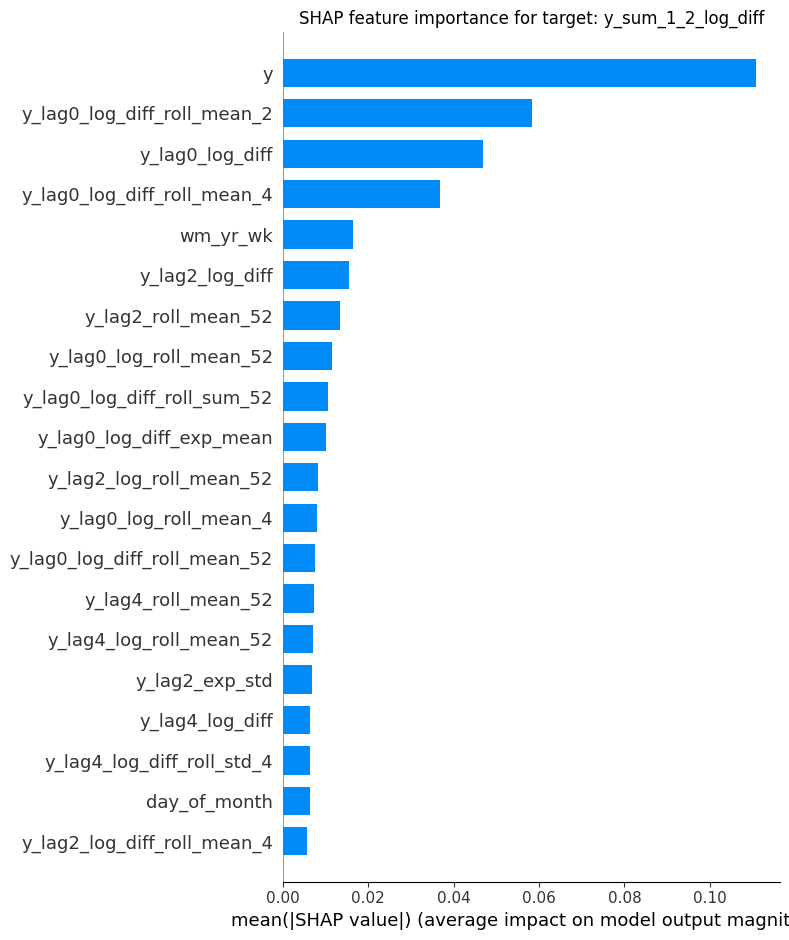

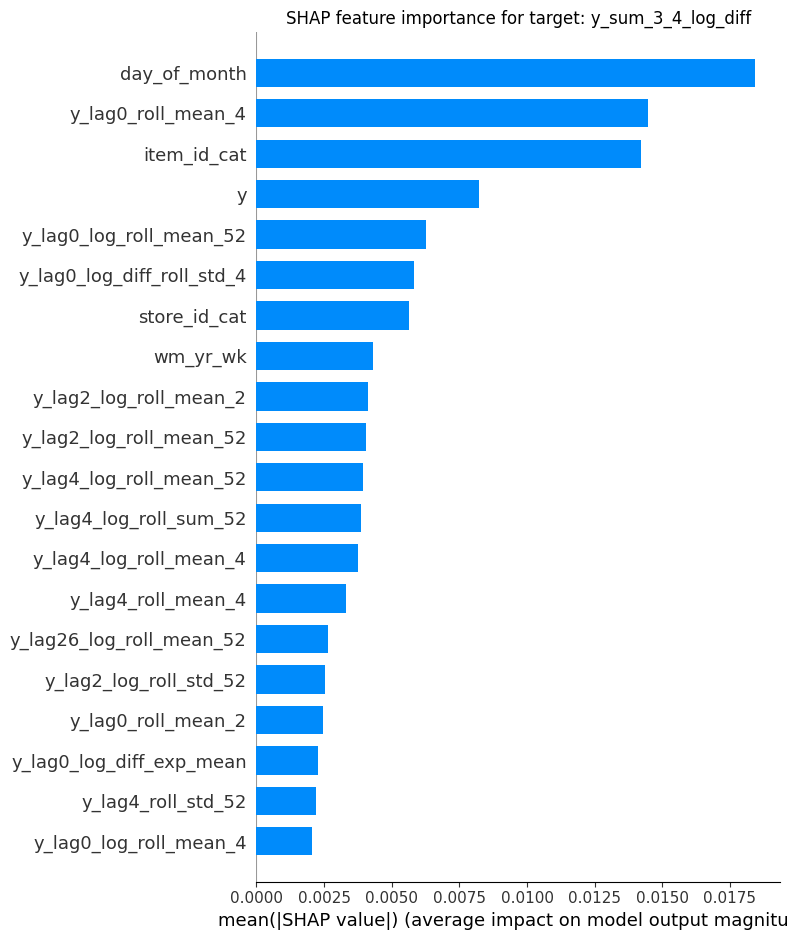

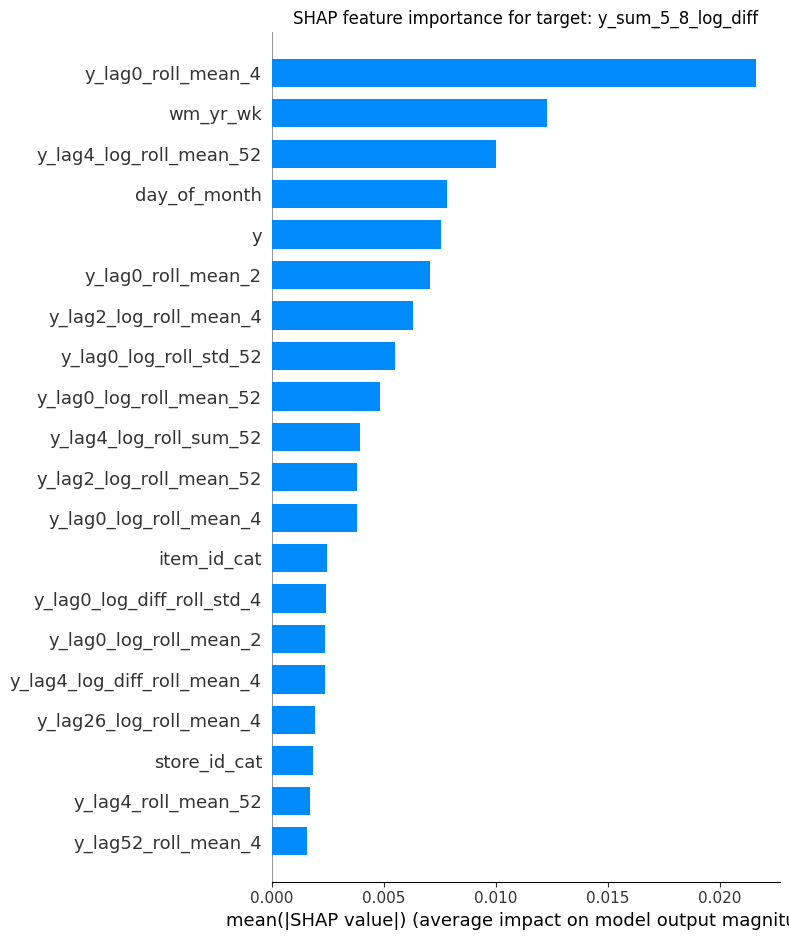

In [102]:
import shap
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor

# 1) Fit your multi‐output model
# 2) For each output dimension, build a SHAP explainer & get values
shap_values = []
for i, tc in enumerate(target_cols):
    # pick the i-th fitted estimator
    est = model.estimators_[i]
    
    # build a SHAP explainer on that one
    expl = shap.TreeExplainer(est)
    
    # compute SHAP values for your test set
    sv = expl.shap_values(X_test)  # shape = (n_test, p)
    shap_values.append(sv)
    
    # 3) plot
    plt.figure(figsize=(8, 5))
    shap.summary_plot(
        sv, X_test,
        feature_names=feature_cols,
        show=False,
        plot_type="bar",
        max_display=20
    )
    plt.title(f"SHAP feature importance for target: {tc}")
    plt.tight_layout()
    plt.show()
